In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def read_data(filepath):
    a_x=[]
    a_y=[]
    a_z=[]
    with open(filepath, 'rb') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            a_x.append(float(row[2]))
            a_y.append(float(row[3]))
            a_z.append(float(row[4]))
    return np.array(a_x),np.array(a_y),np.array(a_z)


0


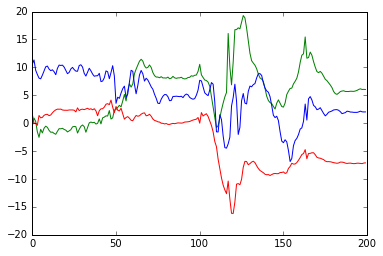

1


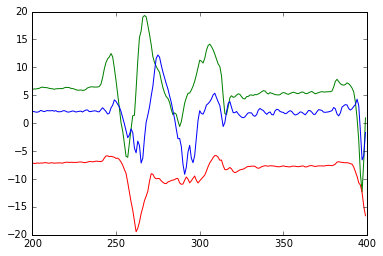

2


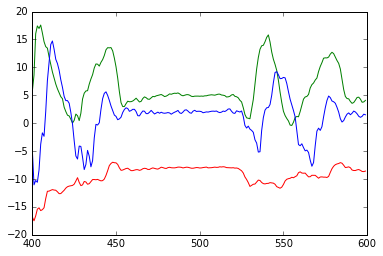

3


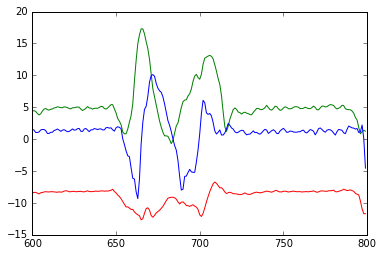

4


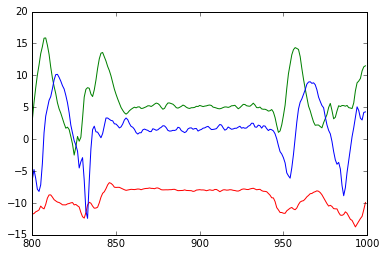

5


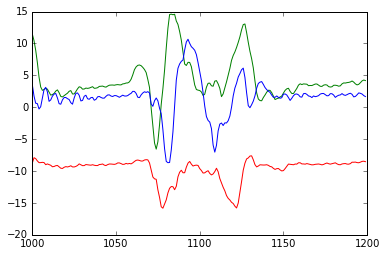

6


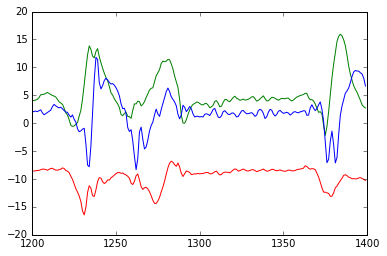

In [4]:
a_x,a_y,a_z = read_data('gestures/O.csv')
division = 200
count = 0 
s = [100,250,375,510,640,780,925,1050,1200]
e = [225,380,560,770,960,1170,1400,1600,1780,2000]
for i in range(0,len(a_x)-division,division):
    start = i
    end = i+division
    #start = s[count]
    #end = s[count]+100
    print count
    plt.plot(range(start,end),a_x[start:end],color = 'g')
    plt.plot(range(start,end),a_y[start:end],color = 'r')
    plt.plot(range(start,end),a_z[start:end],color = 'b')
    plt.show()
    count+=1

In [5]:
def add_features(feature_array,filepath, s = None):
    a_x,a_y,a_z = read_data(filepath)
    label = filepath.split('/')[1].split('.')[0]
    division = 100
    if s == None:
        for i in range(180,len(a_x)-division,division):
            start = i
            end = i+division
            acc = np.append(np.append(a_x[start:end],a_y[start:end]),a_z[start:end])
            feature_array=np.vstack([feature_array,np.append(acc,label)])
    else:
        for i in range(len(s)):
            start = s[i]
            end = start + division
            acc = np.append(np.append(a_x[start:end],a_y[start:end]),a_z[start:end])
            feature_array=np.vstack([feature_array,np.append(acc,label)])
    return feature_array

In [6]:
Data = np.zeros(301)
Data = add_features(Data,'gestures/quick_turn.csv')
s = [125,280,460,670,860,1070,1300,1500,1680,1890]
Data = add_features(Data,'gestures/arm_out.csv',s)
s = [0,175,325,475,610,750,900,1075,1270,1440,1640]
Data = add_features(Data,'gestures/across.csv',s)
s = [100,250,375,510,640,780,925,1050,1200]
Data = add_features(Data,'gestures/O.csv',s)
s = [50,175,300,400,500,600,700,790,880,980,1100,1200,1300,1450,1600,1700]
Data = add_features(Data,'gestures/V.csv',s)
s = range(50,1075,100)
Data = add_features(Data,'gestures/tap.csv',s)
Data = np.delete(Data,0,0)
Data.shape

(67, 301)

In [82]:
training_df = pd.DataFrame([Data[1,:-1],Data[11,:-1],Data[32,:-1],Data[41,:-1],Data[57,:-1]])
training_df.head()
training_df.to_csv('training.csv',header = False)

In [95]:
all_df = pd.DataFrame(Data[:,:-1])
all_df.to_csv('all.csv',header = False)

In [6]:
import pickle
with open("feature_data.pkl", 'w') as datafile:
    pickle.dump(Data, datafile)

In [53]:
import pickle
with open("feature_data.pkl", 'r') as datafile:
    Data = pickle.load(datafile)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

def Classifier_Acc(features,label,classifier = 'NaiveBayes'):
    '''returns the accuracy of the predicted results of the model. percent_data is the perentage 
        of the data used to create the model'''
    classifier_dict = {'RandomForest':RandomForestClassifier(),'DecisionTree':DecisionTreeClassifier(),
                       'KNeighbors':KNeighborsClassifier(n_neighbors=2),'SVC':SVC(C = 4),'NaiveBayes':GaussianNB()
                    }
    label_dict = {}
    for lab in label:
        label_dict[lab]=False
    
    accuracy = []
    for count in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(features,label,
                                                    test_size=0.50, random_state=count)
        
        #for lab in y_train:
        #    if lab in label_dict:
        #        label_dict[lab]=True
        
            
        model = GaussianNB()
        results = model.fit(X_train, y_train)

        accuracy.append(accuracy_score(results.predict(X_test),y_test))
    return np.mean(accuracy)

Classifier_Acc(Trunc_Filt_FFT_Data[:,:-1].astype(float),Trunc_Filt_FFT_Data[:,-1])

NameError: name 'Trunc_Filt_FFT_Data' is not defined

In [24]:
import random

def Train_Test_Split(data,numTraining=5):
    label_dict = {}
    for label in data[:,-1]:
        if label not in label_dict:
            label_dict[label]=0
    
    X_train = []
    y_train = []
    
    while (all(val==numTraining for val in label_dict.values()) == False): #loop while each label doesnt have numTraining example
        num_rows = data.shape[0]
        row = random.randint(0,num_rows-1)
        if label_dict[data[row,-1]] < numTraining: #if there are less than 5 training example with that label
            X_train.append(data[row,:-1])
            y_train.append(data[row,-1])
            label_dict[data[row,-1]]+=1
            data = np.delete(data,row,0)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = data[:,:-1]
    y_test = data[:,-1]
    
    return X_train, y_train, X_test, y_test

def model_accuracy(data,classifier = 'RandomForest', numTraining = 5):
    classifier_dict = {'RandomForest':RandomForestClassifier(),'DecisionTree':DecisionTreeClassifier(),
                       'KNeighbors':KNeighborsClassifier(n_neighbors=1,p=1),
                       'SVC':SVC(C = 4),'NaiveBayes':GaussianNB()}
    label_dict = {}
    for label in data[:,-1]:
        if label not in label_dict:
            label_dict[label]=0
    
    X_train = []
    y_train = []
    
    while (all(val==numTraining for val in label_dict.values()) == False): #loop while each label doesnt have numTraining example
        num_rows = data.shape[0]
        row = random.randint(0,num_rows-1)
        if label_dict[data[row,-1]] < numTraining: #if there are less than 5 training example with that label
            X_train.append(data[row,:-1])
            y_train.append(data[row,-1])
            label_dict[data[row,-1]]+=1
            data = np.delete(data,row,0)

    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train)
    
    X_test = data[:,:-1].astype(float)
    y_test = data[:,-1]
    
    model = classifier_dict[classifier]
    results = model.fit(X_train, y_train)
    
    return accuracy_score(results.predict(X_test),y_test)

def multi_simulation_accuracy(data,classifier = 'DecisionTree', numTraining = 5,numSimulations = 200):
    total = 0
    for i in range(numSimulations):
        total += model_accuracy(data,classifier,numTraining)
    return total/numSimulations

# def all_model_accuracies(data,numTraining = 5, numSimulations = 100):
#     d = []
#     classifiers = ['NaiveBayes','DecisionTree','SVC','RandomForest','KNeighbors']
#     for c in classifiers:
#         d.append((c,multi_simulation_accuracy(data,classifier = c,numTraining,numSimulations)))
#     return d

In [8]:
def lowpass_filter(actual_data,alpha):
    samples = 100
    filtered_data = [float(actual_data[0])]
    for i in range(1,samples):
        new_reading = alpha*float(actual_data[i-1])+(1-alpha)*filtered_data[i-1]
        filtered_data.append(new_reading)
    return filtered_data

In [9]:
def plot_gesture(Data,row,start=0,end=100,title = 'None'): 
    fig, p = plt.subplots()
    
    p.plot(Data[row,start:end],label='a_x')
    p.plot(Data[row,(start+100):(end+100)],label='a_y')
    p.plot(Data[row,(start+200):(end+200)],label='a_z')
    p.set_title(title)

    p.set_xlabel('Sample')
    p.set_ylabel('Acceleration (m/s^2)')
    p.legend(loc='best', shadow=True)
    plt.show

In [10]:
def apply_lowpass_filter(Data,alpha):
    feature_array = np.zeros(301)
    for row in range(Data.shape[0]):
        ax_filtered = lowpass_filter(Data[row,:100],alpha)
        ay_filtered = lowpass_filter(Data[row,100:200],alpha)
        az_filtered = lowpass_filter(Data[row,200:300],alpha)
        acc = np.append(np.append(ax_filtered,ay_filtered),az_filtered)
        feature_array=np.vstack([feature_array,np.append(acc,Data[row,-1])])
    feature_array = np.delete(feature_array,0,0)
    return feature_array

In [11]:
Filtered_Data = apply_lowpass_filter(Data,.1)

In [13]:
import pickle
with open("filtered_data.pkl", 'w') as datafile:
    pickle.dump(Filtered_Data, datafile)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def get_accel(Data,row):
    return Data[row,:100].astype(float), Data[row,100:200].astype(float), Data[row,200:300].astype(float)
   
def truncate(Data,row,beta):
    ax,ay,az = get_accel(Data,row)
    combined_std = np.sqrt(np.std(ax)**2+np.std(ay)**2+np.std(az)**2)
    threshold = beta*combined_std
    
    first_point = (ax[0],ay[0],az[0])
    start_index=0
    for i in range(1,len(ax)):
        norm = np.sqrt((ax[i]-first_point[0])**2+(ay[i]-first_point[1])**2+(az[i]-first_point[2])**2)
        if norm > threshold:
            start_index = i
            break
    
    last_point = (ax[-1],ay[-1],az[-1])
    end_index = 100
    for j in range(len(ax)-2,0,-1):
        norm = np.sqrt((ax[j]-last_point[0])**2+(ay[j]-last_point[1])**2+(az[j]-last_point[2])**2)
        if norm > threshold:
            end_index = j
            break    

    return start_index,end_index

In [14]:
def interpolate(Data,row,start,end):
    r = np.arange(100)
    r = r/float(100)*(end-start)+start
    ax = np.interp(r,range(start,end),Filtered_Data[row,start:end].astype(float))
    ay = np.interp(r+100,range(start+100,end+100),Filtered_Data[row,start+100:end+100].astype(float))
    az = np.interp(r+200,range(start+200,end+200),Filtered_Data[row,start+200:end+200].astype(float))
    return np.append(np.append(ax,ay),az)

In [15]:
from copy import deepcopy

def apply_truncation(Data,beta):
    truncated_data = np.zeros(301)
    for row in range(Data.shape[0]):
        start_index,end_index = truncate(Data,row,beta)
        truncated_data=np.vstack([truncated_data,np.append(interpolate(Data,row,start_index,end_index),Data[row,-1])])
    truncated_data = np.delete(truncated_data,0,0)
    return truncated_data

Trunc_Filt_Data = apply_truncation(Filtered_Data,1)
Trunc_Filt_Data.shape

(67, 301)

In [18]:
import pickle
with open("Trunc_Filt_Data.pkl", 'w') as datafile:
    pickle.dump(Trunc_Filt_Data, datafile)

In [16]:
def add_fft(Data,n, includeAngle = False):
    multiplier = 1 
    if includeAngle:
        multiplier = 2
    fft_features = np.zeros(n*multiplier*3+1)
    for row in range(Data.shape[0]):
        fft_x = np.fft.fft(Data[row,:100].astype(float),n)
        fft_y = np.fft.fft(Data[row,100:200].astype(float),n)
        fft_z = np.fft.fft(Data[row,200:300].astype(float),n)
        mag = np.append(np.append(np.absolute(fft_x),np.absolute(fft_y)),np.absolute(fft_z))
        if includeAngle:
            angle = np.append(np.append(np.angle(fft_x),np.angle(fft_y)),np.angle(fft_z))
            mag = np.append(mag,angle)
        fft_features=np.vstack([fft_features,np.append(mag,Data[row,-1])])
    fft_features = np.delete(fft_features,0,0)
    return fft_features

FFT_Data = add_fft(Trunc_Filt_Data,40)

In [17]:
Trunc_Filt_FFT_Data = np.append(Trunc_Filt_Data[:,:-1],FFT_Data,axis=1)

V


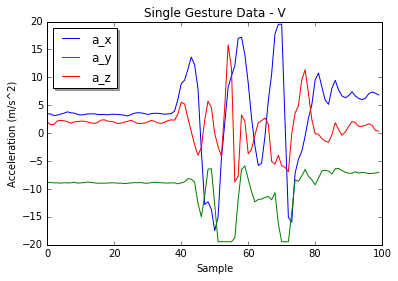

In [25]:
print Data[52,-1]
g = 52
plot_gesture(Data,g,title = 'Single Gesture Data - V')

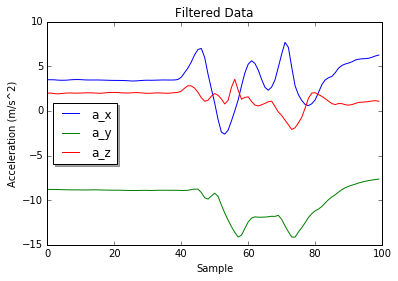

In [22]:
plot_gesture(Filtered_Data,g,title = 'Filtered Data')

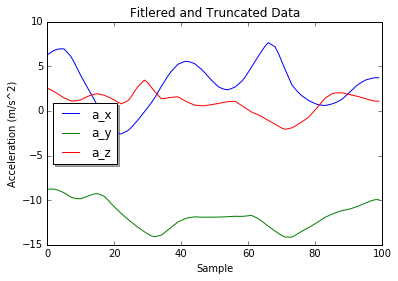

In [23]:
plot_gesture(Trunc_Filt_Data,g,title = 'Fitlered and Truncated Data')

In [24]:
d = [Data,Filtered_Data,Trunc_Filt_Data,Trunc_Filt_FFT_Data]
c  = ['NaiveBayes','DecisionTree','SVC','RandomForest','KNeighbors']
#for dataset in d:
print multi_simulation_accuracy(np.concatenate((Data[:,:-1].astype(float),Data[:,-1].reshape(-1,1)),axis = 1),
                                classifier = 'NaiveBayes',numTraining = 5 )

0.758378378378


In [25]:
import pickle
with open("Trunc_Filt_Data_FFT.pkl", 'w') as datafile:
    pickle.dump(Trunc_Filt_FFT_Data, datafile)

In [26]:
import pickle
with open("Trunc_Filt_Data1.pkl", 'r') as datafile:
    Trunc_Filt_Data = pickle.load(datafile)

In [90]:
#import mlpy
from sklearn.neighbors import DistanceMetric

def dtw_distance(x,y):
    distances = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            distances[i,j] = (x[j]-y[i])**2 
            #distances[i,j] = abs(x[j]-y[i])
    accumulated_cost = np.zeros((len(y), len(x)))
    accumulated_cost[0,0] = distances[0,0]
    for i in range(1, len(x)):
        accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]
    for i in range(1, len(y)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0] 
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(y)-1
    j = len(x)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], 
                                               accumulated_cost[i-1, j], 
                                               accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], 
                                                 accumulated_cost[i-1, j], 
                                                 accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost +distances[x, y]
    return cost 
    
    
def distance_metric(gesture1,gesture2):
    gesture1 = gesture1.astype(float)
    gesture2 = gesture2.astype(float)
    dist_x = dtw_distance(gesture1[:100], gesture2[:100])
    dist_y = dtw_distance(gesture1[100:200], gesture2[100:200])
    dist_z = dtw_distance(gesture1[200:300], gesture2[200:300])
    #return np.sqrt(np.sum(np.square(np.array([dist_x,dist_y,dist_z]))))
    return np.sum(np.array([dist_x,dist_y,dist_z]))


print dtw_distance(Data[1,:-1].astype(float),Data[11,:-1].astype(float))
print distance_metric(Data[1,:-1].astype(float),Data[11,:-1].astype(float))



8721.095618
14277.633434


In [19]:
def find_dtw_distances(Data1,Data2):
    distances = []
    for i in range(Data1.shape[0]):
        for j in range(Data2.shape[0]):
            if Data1[i,-1]==Data2[j,-1]:
                dist = distance_metric(Data1[i,:-1].astype(float),Data2[j,:-1].astype(float))
                distances.append((dist,Data1[i,-1],Data2[j,-1]))
    return sorted(distances,reverse = True)

#find_dtw_distances(Filtered_Data,Filtered_Data)

In [20]:
def custom_KNN(data,n=1):
    label_dict = {}
    for label in data[:,-1]:
        if label not in label_dict:
            label_dict[label]=0
    
    X_train = []
    y_train = []
    
    while (all(val==1 for val in label_dict.values()) == False): #loop while each label doesnt have numTraining example
        num_rows = data.shape[0]
        row = random.randint(0,num_rows-1)
        if label_dict[data[row,-1]] < 1: #if there are less than 5 training example with that label
            X_train.append(data[row,:-1])
            y_train.append(data[row,-1])
            label_dict[data[row,-1]]+=1
            data = np.delete(data,row,0)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = data[:,:-1]
    y_test = data[:,-1]
    
    labels = []
    for test_index,test in enumerate(X_test):
        distances = []
        for train_index,train in enumerate(X_train):
            distances.append((distance_metric(test,train),y_train[train_index]))
        labels.append(min(distances)[1])    
    print len(labels)
        
    return accuracy_score(labels,y_test)

#custom_KNN(Data)


In [21]:
import timeit

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def KNN_predict(X_test):
    minimum = 0 
    for train_index,train in enumerate(X_train):
        minumum = min(minimum,distance_metric(X_test,train)*-1)
    return minimum*-1

In [69]:
X_train, y_train, X_test, y_test = Train_Test_Split(Trunc_Filt_Data,numTraining = 1)

model = KNeighborsClassifier(n_neighbors=1)
results = model.fit(X_train, y_train)
 
wrapped = wrapper(results.predict,X_test[0].reshape(1,-1))
print timeit.timeit(wrapped, number=1)

wrapped = wrapper(model.kneighbors,X_test[0].reshape(1,-1))
print timeit.timeit(wrapped, number=1)

model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

print timeit.timeit(wrapped, number=1)

model = RandomForestClassifier()
results = model.fit(X_train, y_train)

print timeit.timeit(wrapped, number=1)

wrapped = wrapper(KNN_predict,X_test[0])

print timeit.timeit(wrapped, number=1)

0.000914096832275
0.000610113143921
0.000672101974487
0.000478029251099
0.259469032288


In [70]:
import socket, traceback

host = ''
port = 5555

s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
s.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
s.bind((host, port))

while 1:
    try:
        message, address = s.recvfrom(8192)
        print (message)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        traceback.print_exc()

KeyboardInterrupt: 

In [55]:
import socket, traceback

signal_x = np.zeros(100)
signal_y = np.zeros(100)
signal_z = np.zeros(100) 

host = ''
port = 50000
 
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
s.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
s.bind((host, port))
 
#used for debugging
 
print("Success binding")
while 1:
    message, address = s.recvfrom(8192)
    messageString = message.decode("utf-8")
    #print messageString
    signal_x = np.roll(signal_x,-1)
    signal_y = np.roll(signal_y,-1)
    signal_z = np.roll(signal_z,-1)

    signal_x[-1]=float(messageString.split(',')[2][:-1])
    signal_y[-1]=float(messageString.split(',')[3][:-1])
    signal_z[-1]=float(messageString.split(',')[4][:-1])      
     
     
# Example of XML data received:
# <Node Id>node12</Node Id>
# <GPS>
# <Latitude>1.123123</Latitude>
# <Longitude>234.1231231</Longitude>
# <Accuracy>40.0</Accuracy>
# </GPS>
# <Accelerometer>
# <Accelerometer1>0.38444442222</Accelerometer1>
# <Accelerometer2>0.03799999939</Accelerometer2>
# <Accelerometer3>9.19400000331</Accelerometer3>
# </Accelerometer>
# <TimeStamp>1370354489083</TimeStamp>

Success binding


KeyboardInterrupt: 

 6951.07880035 tap
1417.2368883 across


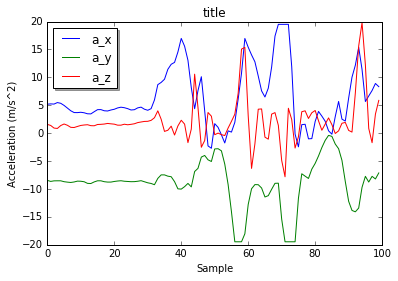

In [62]:
fig, p = plt.subplots()

p.plot(signal_x,label='a_x')
p.plot(signal_y,label='a_y')
p.plot(signal_z,label='a_z')
p.set_title('title')

p.set_xlabel('Sample')
p.set_ylabel('Acceleration (m/s^2)')
p.legend(loc='best', shadow=True)
plt.show

min_dist = 100000
for index,g in enumerate(tg):

    dist_x = dtw_distance(g[:100].astype(float),signal_x)
    dist_y = dtw_distance(g[100:200].astype(float),signal_y)
    dist_z = dtw_distance(g[200:300].astype(float),signal_z)
    dist = np.sqrt(np.sum(np.square(np.array([dist_x,dist_y,dist_z]))))

    if dist == min(dist,min_dist):
        min_dist = dist
        min_index = index

        if min_dist < 10000:
            print min_dist, tg[min_index,-1]

In [22]:
def find_distance(Data1,Data2):
    distances = []
    for i in range(Data1.shape[0]):
        for j in range(Data2.shape[0]):
            if Data1[i,-1]==Data2[j,-1]:
                dist = np.sum(np.absolute(np.subtract(Data1[i,:-1].astype(float),Data2[j,:-1].astype(float))))
                distances.append((dist,Data1[i,-1],Data2[j,-1]))
    return sorted(distances,reverse = True)
            

In [75]:
Training_Gestures,Training_Labels,_,_ = Train_Test_Split(Data,numTraining = 1)
tg =  np.concatenate((Training_Gestures,Training_Labels.reshape(-1,1)),axis = 1)
model = KNeighborsClassifier(n_neighbors=1)
results = model.fit(tg[:,:-1].astype(float), tg[:,-1])
d=[]
for i in range(Data.shape[0]):
    dist, ind = model.kneighbors(Data[i,:-1])
    d.append(dist)
print sorted(d,reverse = True)

[array([[ 115.49737668]]), array([[ 115.24977893]]), array([[ 114.64385]]), array([[ 114.13336566]]), array([[ 108.43529061]]), array([[ 107.24420934]]), array([[ 106.36042039]]), array([[ 105.28558349]]), array([[ 104.79382235]]), array([[ 102.80851719]]), array([[ 101.66820465]]), array([[ 101.5462815]]), array([[ 99.38280815]]), array([[ 98.99935991]]), array([[ 98.44760785]]), array([[ 98.33248323]]), array([[ 97.63903389]]), array([[ 96.2242464]]), array([[ 95.98963217]]), array([[ 95.86341911]]), array([[ 95.84048853]]), array([[ 92.41806069]]), array([[ 91.67432277]]), array([[ 91.50273358]]), array([[ 90.40690026]]), array([[ 90.10447065]]), array([[ 89.42417004]]), array([[ 88.44344471]]), array([[ 87.26449552]]), array([[ 87.23694334]]), array([[ 85.2938358]]), array([[ 83.41446511]]), array([[ 83.16455005]]), array([[ 83.01531634]]), array([[ 82.459244]]), array([[ 82.09375972]]), array([[ 81.77902028]]), array([[ 80.85368718]]), array([[ 80.3169744]]), array([[ 78.73556528]

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

In [20]:
def start_stream(gestures,filepath):
    signal_x = np.zeros(100)
    signal_y = np.zeros(100)
    signal_z = np.zeros(100)

    model = KNeighborsClassifier(n_neighbors=1)
    results = model.fit(gestures[:,:-1].astype(float), gestures[:,-1])
    with open(filepath, 'rb') as f:
        reader = csv.reader(f, delimiter=',')
        count = 0 
        for row in reader:

            signal_x = np.roll(signal_x,-1)
            signal_y = np.roll(signal_y,-1)
            signal_z = np.roll(signal_z,-1)

            signal_x[-1]=float(row[2])
            signal_y[-1]=float(row[3])
            signal_z[-1]=float(row[4])
                
            if (np.sqrt(np.sum([np.std(signal_x),np.std(signal_y),np.std(signal_z)]))) > 2.8:
                label = results.predict(np.append(np.append(signal_x,signal_y),signal_z))
                dist, ind = model.kneighbors(Data[i,:-1])
#                 min_dist = 100000
#                 min_index = 20
#                 for index,g in enumerate(gestures):

#                     dist_x = dtw_distance(g[:100].astype(float),signal_x)
#                     dist_y = dtw_distance(g[100:200].astype(float),signal_y)
#                     dist_z = dtw_distance(g[200:300].astype(float),signal_z)
#                     dist = np.sqrt(np.sum(np.square(np.array([dist_x,dist_y,dist_z]))))

#                     if dist == min(dist,min_dist):
#                         min_dist = dist
#                         min_index = index
#                 if min_dist < 2200:
                if dist < 116:
                    print label
            print count
            count += 1

In [83]:
start_stream(tg,'gestures/V.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
['tap']
43
['tap']
44
['tap']
45
['tap']
46
['tap']
47
['tap']
48
['tap']
49
['tap']
50
['tap']
51
['tap']
52
['tap']
53
['tap']
54
['tap']
55
['tap']
56
['tap']
57
['tap']
58
['tap']
59
['tap']
60
['tap']
61
['tap']
62
['tap']
63
['tap']
64
['tap']
65
['tap']
66
['tap']
67
['arm_out']
68
['arm_out']
69
['arm_out']
70
['arm_out']
71
['arm_out']
72
['arm_out']
73
['arm_out']
74
['arm_out']
75
['arm_out']
76
['arm_out']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


77
['arm_out']
78
['arm_out']
79
['arm_out']
80
['arm_out']
81
['O']
82
['O']
83
['O']
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
['O']
102
['O']
103
['O']
104
['O']
105
['O']
106
['O']
107
['O']
108
['O']
109
['O']
110
['O']
111
['O']
112
['O']
113
['O']
114
['O']
115
['across']
116
['across']
117
['across']
118
['across']
119
['across']
120
['across']
121
['O']
122
['O']
123
['O']
124
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


125
['O']
126
['O']
127
['O']
128
['O']
129
['O']
130
['O']
131
['O']
132
['O']
133
['O']
134
['O']
135
['O']
136
['O']
137
['O']
138
['O']
139
['O']
140
['O']
141
['O']
142
['O']
143
['O']
144
['O']
145
['O']
146
['across']
147
['across']
148
['across']
149
['across']
150
['across']
151
['across']
152
['across']
153
['across']
154
['across']
155
['across']
156
['across']
157
['across']
158
['across']
159
['across']
160
['O']
161
['O']
162
['O']
163
['O']
164
['O']
165
['O']
166
['O']
167
['O']
168
['O']
169
['O']
170
['O']
171
['O']
172
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


173
['O']
174
['O']
175
['O']
176
['O']
177
['O']
178
['O']
179
['O']
180
['O']
181
['O']
182
['arm_out']
183
['V']
184
['V']
185
['V']
186
['across']
187
['across']
188
['across']
189
['across']
190
['across']
191
['across']
192
['across']
193
['across']
194
['O']
195
['O']
196
['O']
197
['O']
198
['O']
199
['O']
200
['O']
201
['O']
202
['O']
203
['O']
204
['V']
205
['O']
206
['O']
207
['O']
208
['O']
209
['O']
210
['O']
211
['O']
212
['O']
213
['O']
214
['O']
215
['O']
216
['O']
217
['O']
218
['O']
219
['O']
220
['O']
221
['O']
222
['O']
223
['O']
224
['O']
225
['V']
226
['V']
227
['O']
228
['O']
229
['O']
230
['O']
231
['O']
232
['O']
233
['O']
234
['O']
235
['O']
236
['O']
237
['O']
238
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


239
['O']
240
['O']
241
['O']
242
['O']
243
['O']
244
['O']
245
['O']
246
['O']
247
['O']
248
['O']
249
['O']
250
['O']
251
['O']
252
['O']
253
['O']
254
['O']
255
['O']
256
['O']
257
['O']
258
['O']
259
['O']
260
['O']
261
['across']
262
['across']
263
['across']
264
['across']
265
['across']
266
['O']
267
['O']
268
['O']
269
['O']
270
['O']
271
['O']
272
['O']
273
['V']
274
['O']
275
['O']
276
['O']
277
['quick_turn']
278
['quick_turn']
279
['O']
280
['O']
281
['O']
282
['O']
283
['O']
284
['O']
285
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


286
['O']
287
['O']
288
['O']
289
['O']
290
['O']
291
['V']
292
['V']
293
['V']
294
['V']
295
['O']
296
['O']
297
['O']
298
['across']
299
['O']
300
['O']
301
['O']
302
['V']
303
['V']
304
['V']
305
['O']
306
['O']
307
['O']
308
['O']
309
['O']
310
['O']
311
['O']
312
['O']
313
['V']
314
['V']
315
['V']
316
['V']
317
['O']
318
['O']
319
['O']
320
['O']
321
['O']
322
['O']
323
['O']
324
['O']
325
['O']
326
['O']
327
['O']
328
['O']
329
['O']
330
331
332
333
334
335
336
337
338
339
['O']
340
['O']
341
['O']
342
['O']
343
['O']
344
['O']
345
['O']
346
['O']
347
['O']
348
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


349
['O']
350
['O']
351
['O']
352
['O']
353
['O']
354
['O']
355
['O']
356
['O']
357
['O']
358
['O']
359
['O']
360
['O']
361
['O']
362
['O']
363
['O']
364
['O']
365
['O']
366
['O']
367
['O']
368
['O']
369
['O']
370
['O']
371
['O']
372
['O']
373
['O']
374
['O']
375
['O']
376
['O']
377
['O']
378
['O']
379
['O']
380
['O']
381
['O']
382
['O']
383
['O']
384
['O']
385
['O']
386
['O']
387
['O']
388
['O']
389
['O']
390
['O']
391
['O']
392
['O']
393
['O']
394
['O']
395
['O']
396
['V']
397
['V']
398
['V']
399
['V']
400
['V']
401
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


402
['V']
403
['quick_turn']
404
['O']
405
['O']
406
['O']
407
['O']
408
['O']
409
['O']
410
['O']
411
['O']
412
['O']
413
['O']
414
['O']
415
['O']
416
['O']
417
['V']
418
['V']
419
['V']
420
['V']
421
['V']
422
['O']
423
['O']
424
['O']
425
['O']
426
['V']
427
['O']
428
['O']
429
['O']
430
['O']
431
['O']
432
['O']
433
['O']
434
['O']
435
['O']
436
['O']
437
['O']
438
['O']
439
['O']
440
['O']
441
['O']
442
['O']
443
['O']
444
['O']
445
['O']
446
['O']
447
['O']
448
['O']
449
['O']
450
['O']
451
['O']
452
['O']
453
['O']
454
['O']
455
['O']
456
['O']
457
['O']
458
['O']
459
['O']
460
['O']
461
['O']
462
['O']
463
['O']
464
['O']
465
['O']
466
['O']
467
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


468
['O']
469
['O']
470
['O']
471
['O']
472
['O']
473
['O']
474
['across']
475
['across']
476
['across']
477
['across']
478
['across']
479
['across']
480
['across']
481
['across']
482
['across']
483
['across']
484
['O']
485
['O']
486
['O']
487
['O']
488
['O']
489
['O']
490
['O']
491
['O']
492
['O']
493
['O']
494
['O']
495
['O']
496
['O']
497
['O']
498
['O']
499
['O']
500
['O']
501
['O']
502
['O']
503
['O']
504
['O']
505
['O']
506
['O']
507
['O']
508
['O']
509
['O']
510
['O']
511
['across']
512
['across']
513
['across']
514
['across']
515
['across']
516
['across']
517
['across']
518
['O']
519
['V']
520
['O']
521
['O']
522
['O']
523
['O']
524
['O']
525
['O']
526
['O']
527
['O']
528
['O']
529
['O']
530
['O']
531
['O']
532
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


533
['O']
534
['O']
535
['O']
536
['O']
537
['O']
538
['O']
539
['O']
540
['O']
541
['O']
542
['O']
543
['O']
544
['O']
545
['O']
546
['O']
547
['O']
548
['O']
549
['O']
550
['O']
551
['O']
552
['O']
553
['O']
554
['O']
555
['O']
556
['O']
557
['O']
558
['O']
559
['O']
560
['O']
561
['O']
562
['O']
563
['O']
564
['O']
565
['O']
566
['O']
567
['O']
568
['O']
569
['O']
570
['O']
571
['O']
572
['O']
573
['O']
574
['O']
575
['O']
576
['O']
577
['O']
578
['O']
579
['O']
580
['O']
581
['O']
582
['O']
583
['O']
584
['O']
585
['O']
586
['O']
587
['O']
588
['O']
589
['O']
590
['across']
591
['across']
592
['across']
593
['across']
594
['across']
595
['across']
596
['across']
597
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


598
['V']
599
['V']
600
['quick_turn']
601
['quick_turn']
602
['quick_turn']
603
['quick_turn']
604
['O']
605
['O']
606
['O']
607
['O']
608
['O']
609
['O']
610
['O']
611
['O']
612
['V']
613
['V']
614
['V']
615
['V']
616
['V']
617
['V']
618
['V']
619
['O']
620
['O']
621
['O']
622
['O']
623
['O']
624
['O']
625
['O']
626
['O']
627
['across']
628
['V']
629
['V']
630
['V']
631
['V']
632
['V']
633
['V']
634
['V']
635
['O']
636
['O']
637
['O']
638
['O']
639
['O']
640
['O']
641
['O']
642
['V']
643
['V']
644
['V']
645
['O']
646
['O']
647
['O']
648
['O']
649
['O']
650
['O']
651
['O']
652
['O']
653
['O']
654
['O']
655
['O']
656
['O']
657
['O']
658
['O']
659
['O']
660
['O']
661
['O']


/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

662
['O']
663
['O']
664
['O']
665
['O']
666
['O']
667
['O']
668
['O']
669
['O']
670
['O']
671
['O']
672
['O']
673
['across']
674
['across']
675
['across']
676
['across']
677
['across']
678
['O']
679
['O']
680
['O']
681
['O']
682
['O']
683
['O']
684
['O']
685
['O']
686
['O']
687
['O']
688
['O']
689
['O']
690
['O']
691
['O']
692
['O']
693
['O']
694
['O']
695
['O']
696
['O']
697
['O']
698
['O']
699
['O']
700
['O']
701
['O']
702
['O']
703
['O']
704
['O']
705
['O']
706
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


707
['O']
708
['O']
709
['O']
710
['O']
711
['O']
712
['across']
713
['V']
714
['V']
715
['V']
716
['V']
717
['V']
718
['O']
719
['O']
720
['O']
721
['O']
722
['O']
723
['O']
724
['O']
725
['O']
726
['O']
727
['O']
728
['O']
729
['O']
730
['O']
731
['O']
732
['O']
733
['O']
734
['O']
735
['O']
736
['O']
737
['O']
738
['O']
739
['O']
740
['O']
741
['O']
742
['O']
743
['O']
744
['O']
745
['O']
746
['O']
747
['O']
748
['O']
749
['O']
750
['O']
751
['O']
752
['O']
753
['O']
754
['O']
755
['O']
756
['O']
757
['O']
758
['O']
759
['O']
760
['O']
761
['O']
762
['O']
763
['O']
764
['O']
765
['O']
766
['O']
767
['O']
768
['O']
769
['O']
770
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


771
['O']
772
['O']
773
['O']
774
['O']
775
['O']
776
['O']
777
['O']
778
['O']
779
['O']
780
['O']
781
['O']
782
['O']
783
['O']
784
['O']
785
['O']
786
['O']
787
['O']
788
['O']
789
['O']
790
['O']
791
['O']
792
['quick_turn']
793
['O']
794
['O']
795
['O']
796
['O']
797
['O']
798
['O']
799
['V']
800
['V']
801
['V']
802
['V']
803
['V']
804
['V']
805
['V']
806
['V']
807
['O']
808
['O']
809
['O']
810
['O']
811
['O']
812
['O']
813
['O']
814
['O']
815
['O']
816
['O']
817
['V']
818
['V']
819
['V']
820
['V']
821
['O']
822
['O']
823
['O']
824
['O']
825
['O']
826
['O']
827
['O']
828
['V']
829
['V']
830
['V']
831
['V']
832
['V']
833
['O']
834
['O']
835
['O']
836
['O']
837
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


838
['O']
839
['O']
840
['O']
841
['O']
842
['O']
843
['O']
844
['O']
845
['O']
846
['O']
847
['O']
848
['O']
849
['O']
850
['O']
851
['O']
852
['O']
853
['O']
854
['O']
855
['O']
856
['O']
857
['O']
858
['O']
859
['O']
860
['O']
861
['O']
862
['O']
863
['O']
864
['O']
865
['O']
866
['O']
867
['O']
868
['O']
869
['O']
870
['O']
871
['O']
872
['O']
873
['O']
874
['O']
875
['O']
876
['V']
877
['V']
878
['V']
879
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


880
['O']
881
['O']
882
['O']
883
['O']
884
['O']
885
['O']
886
['O']
887
['O']
888
['O']
889
['O']
890
['O']
891
['O']
892
['V']
893
['V']
894
['V']
895
['V']
896
['V']
897
['V']
898
['V']
899
['V']
900
['O']
901
['O']
902
['O']
903
['O']
904
['O']
905
['O']
906
['O']
907
['O']
908
['V']
909
['V']
910
['V']
911
['V']
912
['O']
913
['O']
914
['O']
915
['O']
916
['O']
917
['O']
918
['O']
919
['O']
920
['V']
921
['V']
922
['V']
923
['V']
924
['V']
925
['V']
926
['V']
927
['O']
928
['O']
929
['O']
930
['O']
931
['O']
932
['O']
933
['O']
934
['O']
935
['O']
936
['O']
937
['O']
938
['O']
939
['O']
940
['O']
941
['O']
942
['O']
943
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


944
['O']
945
['O']
946
['O']
947
['O']
948
['O']
949
['O']
950
['O']
951
['O']
952
['O']
953
['O']
954
['O']
955
['O']
956
['O']
957
['O']
958
['O']
959
['O']
960
['O']
961
['O']
962
['O']
963
['O']
964
['O']
965
['O']
966
['O']
967
['O']
968
['O']
969
['O']
970
['O']
971
['V']
972
['V']
973
['V']
974
['V']
975
['V']
976
['quick_turn']
977
['quick_turn']
978
['quick_turn']
979
['quick_turn']
980
['quick_turn']
981
['O']
982
['O']
983
['O']
984
['O']
985
['O']
986
['O']
987
['V']
988
['V']
989
['V']
990
['V']
991
['V']
992
['V']
993
['V']
994
['V']
995
['O']
996
['O']
997
['O']
998
['O']
999
['O']
1000
['O']
1001
['O']
1002
['O']
1003
['V']
1004
['V']
1005
['V']
1006
['V']
1007
['V']
1008
['O']
1009
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1010
['O']
1011
['O']
1012
['O']
1013
['O']
1014
['O']
1015
['O']
1016
['O']
1017
['V']
1018
['V']
1019
['V']
1020
['V']
1021
['V']
1022
['V']
1023
['O']
1024
['O']
1025
['O']
1026
['O']
1027
['O']
1028
['O']
1029
['O']
1030
['O']
1031
['O']
1032
['O']
1033
['O']
1034
['O']
1035
['O']
1036
['O']
1037
['O']
1038
['O']
1039
['O']
1040
['O']
1041
['O']
1042
['O']
1043
['O']
1044
['O']
1045
['O']
1046
['O']
1047
['O']
1048
['O']
1049
['O']
1050
['O']
1051
['O']
1052
['O']
1053
['O']
1054
['O']
1055
['O']
1056
['O']
1057
['O']
1058
['O']
1059
['O']
1060
['O']
1061
['O']
1062
['O']
1063
['O']
1064
['O']
1065
['O']
1066
['O']
1067
['V']
1068
['V']
1069
['V']
1070
['V']
1071
['V']
1072
['V']
1073
['quick_turn']
1074
['quick_turn']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1075
['quick_turn']
1076
['O']
1077
['O']
1078
['O']
1079
['O']
1080
['O']
1081
['O']
1082
['O']
1083
['O']
1084
['V']
1085
['V']
1086
['V']
1087
['V']
1088
['V']
1089
['V']
1090
['V']
1091
['O']
1092
['O']
1093
['O']
1094
['O']
1095
['O']
1096
['O']
1097
['O']
1098
['O']
1099
['V']
1100
['V']
1101
['V']
1102
['V']
1103
['V']
1104
['O']
1105
['O']
1106
['O']
1107
['O']
1108
['O']
1109
['O']
1110
['O']
1111
['V']
1112
['V']
1113
['V']
1114
['O']
1115
['O']
1116
['O']
1117
['O']
1118
['O']
1119
['O']
1120
['O']
1121
['O']
1122
['O']
1123
['O']
1124
['O']
1125
['O']
1126
['O']
1127
['O']
1128
['O']
1129
['O']
1130
['V']
1131
['V']
1132
['V']
1133
['O']
1134
['O']
1135
['O']
1136
['O']
1137
['O']
1138
['O']
1139
['O']
1140
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1141
['O']
1142
['O']
1143
['O']
1144
['O']
1145
['O']
1146
['O']
1147
['O']
1148
['O']
1149
['O']
1150
['O']
1151
['O']
1152
['O']
1153
['O']
1154
['O']
1155
['O']
1156
['O']
1157
['O']
1158
['O']
1159
['O']
1160
['O']
1161
['O']
1162
['O']
1163
['O']
1164
['O']
1165
['O']
1166
['O']
1167
['O']
1168
['O']
1169
['O']
1170
['O']
1171
['O']
1172
['O']
1173
['O']
1174
['O']
1175
['O']
1176
['O']
1177
['V']
1178
['V']
1179
['V']
1180
['V']
1181
['quick_turn']
1182
['quick_turn']
1183
['quick_turn']
1184
['quick_turn']
1185
['quick_turn']
1186
['O']
1187
['O']
1188
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1189
['O']
1190
['O']
1191
['O']
1192
['V']
1193
['V']
1194
['V']
1195
['V']
1196
['V']
1197
['V']
1198
['V']
1199
['V']
1200
['O']
1201
['O']
1202
['O']
1203
['O']
1204
['O']
1205
['O']
1206
['O']
1207
['O']
1208
['V']
1209
['V']
1210
['V']
1211
['V']
1212
['V']
1213
['O']
1214
['O']
1215
['O']
1216
['O']
1217
['O']
1218
['O']
1219
['O']
1220
['V']
1221
['V']
1222
['O']
1223
['O']
1224
['O']
1225
['O']
1226
['O']
1227
['O']
1228
['O']
1229
['O']
1230
['O']
1231
['O']
1232
['O']
1233
['O']
1234
['O']
1235
['O']
1236
['O']
1237
['O']
1238
['O']
1239
['O']
1240
['O']
1241
['O']
1242
['O']
1243
['O']
1244
['O']
1245
['O']
1246
['O']
1247
['O']
1248
['O']
1249
['O']
1250
['O']
1251
['O']
1252
['O']
1253
['O']
1254
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1255
['O']
1256
['O']
1257
['O']
1258
['O']
1259
['O']
1260
['O']
1261
['O']
1262
['O']
1263
['O']
1264
['O']
1265
['O']
1266
['O']
1267
['O']
1268
['O']
1269
['O']
1270
['O']
1271
['O']
1272
['O']
1273
['O']
1274
['O']
1275
['O']
1276
['O']
1277
['O']
1278
['O']
1279
['O']
1280
['V']
1281
['V']
1282
['V']
1283
['quick_turn']
1284
['quick_turn']
1285
['quick_turn']
1286
['O']
1287
['O']
1288
['O']
1289
['O']
1290
['O']
1291
['O']
1292
['O']
1293
['O']
1294
['O']
1295
['V']
1296
['V']
1297
['V']
1298
['V']
1299
['V']
1300
['V']
1301
['V']
1302
['O']
1303
['O']
1304
['O']
1305
['O']
1306
['O']
1307
['O']
1308
['O']
1309
['O']
1310
['O']
1311
['O']
1312
['O']
1313
['O']
1314
['V']
1315
['V']
1316
['V']
1317
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1318
['V']
1319
['O']
1320
['O']
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
['O']
1351
['O']
1352
['O']
1353
['O']
1354
['O']
1355
['O']
1356
['O']
1357
['O']
1358
['O']
1359
['O']
1360
['O']
1361
['O']
1362
['O']
1363
['V']
1364
['V']
1365
['V']
1366
['V']
1367
['V']
1368
['O']
1369
['O']
1370
['O']
1371
['O']
1372
['O']
1373
['O']
1374
['O']
1375
['O']
1376
['O']
1377
['O']
1378
['O']
1379
['O']
1380
['O']
1381
['O']
1382
['O']
1383
['O']
1384
['O']
1385
['O']
1386
['O']
1387
['O']
1388
['O']
1389
['O']
1390
['O']
1391
['O']
1392
['O']
1393
['O']
1394
['O']
1395
['O']
1396
['O']
1397
['O']
1398
['O']
1399
['O']
1400
['O']
1401
['O']
1402
['O']
1403
['O']
1404
['O']
1405
['O']
1406
['O']
1407
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1408
['O']
1409
['O']
1410
['O']
1411
['V']
1412
['V']
1413
['V']
1414
['V']
1415
['V']
1416
['quick_turn']
1417
['quick_turn']
1418
['quick_turn']
1419
['quick_turn']
1420
['O']
1421
['O']
1422
['O']
1423
['O']
1424
['O']
1425
['O']
1426
['O']
1427
['V']
1428
['V']
1429
['V']
1430
['V']
1431
['V']
1432
['V']
1433
['V']
1434
['V']
1435
['O']
1436
['O']
1437
['O']
1438
['O']
1439
['O']
1440
['O']
1441
['O']
1442
['V']
1443
['V']
1444
['V']
1445
['V']
1446
['O']
1447
['O']
1448
['O']
1449
['O']
1450
['O']
1451
['O']
1452
['O']
1453
['O']
1454
['V']
1455
['V']
1456
['V']
1457
['V']
1458
['O']
1459
['O']
1460
['O']
1461
['O']
1462
['O']
1463
['O']
1464
['O']
1465
['O']
1466
['O']
1467
['O']
1468
['O']
1469
['O']
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
['O']
1483
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1484
['O']
1485
['O']
1486
['O']
1487
['O']
1488
['O']
1489
['O']
1490
['O']
1491
['O']
1492
['O']
1493
['O']
1494
['O']
1495
['V']
1496
['V']
1497
['O']
1498
['O']
1499
['O']
1500
['O']
1501
['O']
1502
['O']
1503
['O']
1504
['O']
1505
['O']
1506
['O']
1507
['O']
1508
['O']
1509
['O']
1510
['O']
1511
['O']
1512
['O']
1513
['O']
1514
['O']
1515
['O']
1516
['O']
1517
['O']
1518
['O']
1519
['O']
1520
['O']
1521
['O']
1522
['O']
1523
['O']
1524
['O']
1525
['O']
1526
['O']
1527
['O']
1528
['O']
1529
['O']
1530
['O']
1531
['O']
1532
['O']
1533
['O']
1534
['O']
1535
['O']
1536
['O']
1537
['O']
1538
['O']
1539
['O']
1540
['O']
1541
['O']
1542
['O']
1543
['V']
1544
['V']
1545
['V']
1546
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1547
['O']
1548
['O']
1549
['O']
1550
['O']
1551
['O']
1552
['O']
1553
['O']
1554
['O']
1555
['O']
1556
['O']
1557
['V']
1558
['V']
1559
['V']
1560
['V']
1561
['V']
1562
['V']
1563
['V']
1564
['V']
1565
['O']
1566
['O']
1567
['O']
1568
['O']
1569
['O']
1570
['O']
1571
['O']
1572
['O']
1573
['O']
1574
['V']
1575
['V']
1576
['V']
1577
['V']
1578
['V']
1579
['V']
1580
['O']
1581
['O']
1582
['O']
1583
['O']
1584
['O']
1585
['O']
1586
['O']
1587
['O']
1588
['O']
1589
['O']
1590
['O']
1591
['O']
1592
['O']
1593
['O']
1594
['O']
1595
['O']
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
['O']
1629
['O']
1630
['O']
1631
['O']
1632
['O']
1633
['O']
1634
['O']
1635
['O']
1636
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1637
['O']
1638
['O']
1639
['O']
1640
['O']
1641
['O']
1642
['O']
1643
['V']
1644
['O']
1645
['O']
1646
['O']
1647
['O']
1648
['O']
1649
['O']
1650
['O']
1651
['O']
1652
['O']
1653
['O']
1654
['O']
1655
['O']
1656
['O']
1657
['O']
1658
['O']
1659
['O']
1660
['O']
1661
['O']
1662
['O']
1663
['O']
1664
['O']
1665
['O']
1666
['O']
1667
['O']
1668
['O']
1669
['O']
1670
['O']
1671
['O']
1672
['O']
1673
['O']
1674
['O']
1675
['O']
1676
['O']
1677
['O']
1678
['O']
1679
['O']
1680
['O']
1681
['O']
1682
['O']
1683
['O']
1684
['O']
1685
['O']
1686
['O']
1687
['O']
1688
['O']
1689
['O']
1690
['V']
1691
['V']
1692
['V']
1693
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1694
['quick_turn']
1695
['quick_turn']
1696
['quick_turn']
1697
['quick_turn']
1698
['O']
1699
['O']
1700
['O']
1701
['O']
1702
['O']
1703
['O']
1704
['O']
1705
['O']
1706
['V']
1707
['V']
1708
['V']
1709
['V']
1710
['V']
1711
['V']
1712
['V']
1713
['O']
1714
['O']
1715
['O']
1716
['O']
1717
['O']
1718
['O']
1719
['O']
1720
['V']
1721
['V']
1722
['V']
1723
['V']
1724
['O']
1725
['O']
1726
['O']
1727
['O']
1728
['O']
1729
['O']
1730
['O']
1731
['O']
1732
['O']
1733
['V']
1734
['V']
1735
['V']
1736
['O']
1737
['O']
1738
['O']
1739
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1740
['O']
1741
['O']
1742
['O']
1743
['O']
1744
['O']
1745
['O']
1746
['O']
1747
['O']
1748
['O']
1749
['O']
1750
['O']
1751
['O']
1752
['O']
1753
['O']
1754
['O']
1755
['O']
1756
['O']
1757
['O']
1758
['O']
1759
['O']
1760
['O']
1761
['V']
1762
['V']
1763
['V']
1764
['O']
1765
['O']
1766
['O']
1767
['O']
1768
['O']
1769
['O']
1770
['O']
1771
['O']
1772
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1773
['O']
1774
['O']
1775
['O']
1776
['O']
1777
['O']
1778
['O']
1779
['O']
1780
['O']
1781
['O']
1782
['O']
1783
['O']
1784
['O']
1785
['O']
1786
['O']
1787
['O']
1788
['O']
1789
['O']
1790
['O']
1791
['O']
1792
['O']
1793
['O']
1794
['O']
1795
['O']
1796
['O']
1797
['O']
1798
['O']
1799
['O']
1800
['O']
1801
['O']
1802
['O']
1803
['O']
1804
['O']
1805
['O']
1806
['O']
1807
['O']
1808
['V']
1809
['V']
1810
['V']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1811
['V']
1812
['quick_turn']
1813
['quick_turn']
1814
['quick_turn']
1815
['quick_turn']
1816
['quick_turn']
1817
['O']
1818
['O']
1819
['O']
1820
['O']
1821
['O']
1822
['O']
1823
['O']
1824
['O']
1825
['quick_turn']
1826
['quick_turn']
1827
['quick_turn']
1828
['V']
1829
['V']
1830
['V']
1831
['V']
1832
['O']
1833
['O']
1834
['O']
1835
['O']
1836
['O']
1837
['quick_turn']
1838
['quick_turn']
1839
['V']
1840
['V']
1841
['V']
1842
['V']
1843
['O']
1844
['O']
1845
['O']
1846
['O']
1847
['O']
1848
['O']
1849
['O']
1850
['O']
1851
['V']
1852
['V']
1853
['V']
1854
['O']
1855
['O']
1856
['O']
1857
['O']
1858
['O']
1859
['O']
1860
['O']
1861
['O']
1862
['O']
1863
['O']
1864
['O']
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
['O']
1876
['O']
1877
['O']
1878
['O']
1879
['O']

/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl


1880
['O']
1881
['O']
1882
['O']
1883
['O']
1884
['O']
1885
['O']
1886
['O']
1887
['V']
1888
['V']
1889
['V']
1890
['V']
1891
['V']
1892
['O']
1893
['O']
1894
['O']
1895
['O']
1896
['O']
1897
['O']
1898
['O']
1899
['O']
1900
['O']
1901
['O']
1902
['O']
1903
['O']
1904
['O']
1905
['O']
1906
['O']
1907
['O']
1908
['O']
1909
['O']
1910
['O']
1911
['O']
1912
['O']
1913
['O']
1914
['O']
1915
['O']
1916
['O']
1917
['O']
1918
['O']
1919
['O']
1920
['O']
1921
['O']
1922
['O']
1923
['O']
1924
['O']
1925
['O']
1926
['O']
1927
['O']
1928
['O']
1929
['O']
1930
['O']
1931
['O']
1932
['O']
1933
['O']
1934
['O']
1935
['V']
1936
['V']
1937
['V']
1938
['V']
1939
['quick_turn']
1940
['quick_turn']
1941
['quick_turn']
1942
['quick_turn']
1943
['O']
1944
['O']
1945
['O']
1946
['O']
1947
['O']
1948
['O']
1949
['O']
1950
['O']
1951
['O']
1952
['V']
1953
['V']
1954
['V']
1955
['V']
1956
['V']
1957
['V']
1958
['V']
1959


/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/dkanarek/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

In [ ]:
#run DTW on filtered and truncated data without interpolation

In [52]:
import socket, traceback

def start_stream_live(gestures):
    signal_x = np.zeros(100)
    signal_y = np.zeros(100)
    signal_z = np.zeros(100)
    gestures[:,:-1]=gestures[:,:-1].astype(float)

 
 
 
    host = ''
    port = 50000

    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
    s.bind((host, port))

    #used for debugging

    print("Success binding")
    while 1:
        message, address = s.recvfrom(8192)
        messageString = message.decode("utf-8") 
        
        signal_x = np.roll(signal_x,-1)
        signal_y = np.roll(signal_y,-1)
        signal_z = np.roll(signal_z,-1)

        signal_x[-1]=float(messageString.split(',')[2][:-1])
        signal_y[-1]=float(messageString.split(',')[3][:-1])
        signal_z[-1]=float(messageString.split(',')[4][:-1])

        if 1:#(np.sqrt(np.sum([np.std(signal_x),np.std(signal_y),np.std(signal_z)]))) > 2.8:
            min_dist = 100000
            min_index = 20
            for index,g in enumerate(gestures):

                dist_x = dtw_distance(g[:100].astype(float),signal_x)
                dist_y = dtw_distance(g[100:200].astype(float),signal_y)
                dist_z = dtw_distance(g[200:300].astype(float),signal_z)
                dist = np.sqrt(np.sum(np.square(np.array([dist_x,dist_y,dist_z]))))

                if dist == min(dist,min_dist):
                    min_dist = dist
                    min_index = index
            if min_dist < 10000:
                print min_dist, gestures[min_index,-1]


In [127]:
def start_stream(gestures,filepath):
    signal_x = np.zeros(100)
    signal_y = np.zeros(100)
    signal_z = np.zeros(100)
    gestures[:,:-1]=gestures[:,:-1].astype(float)
    
    with open(filepath, 'rb') as f:
        reader = csv.reader(f, delimiter=',')
        count = 0 
        for row in reader:
            if count == 0:
    
                signal_x[-1]=float(row[2])
                signal_y[-1]=float(row[3])
                signal_z[-1]=float(row[4])

            else:
                
                signal_x = np.roll(signal_x,-1)
                signal_y = np.roll(signal_y,-1)
                signal_z = np.roll(signal_z,-1)
                
                #apply low pass filter
                signal_x[-1]=.1*float(row[2])+.9*signal_x[-2] #apply low pass filter
                signal_y[-1]=.1*float(row[3])+.9*signal_y[-2]
                signal_z[-1]=.1*float(row[4])+.9*signal_z[-2]
                
#                 if count > 100:
#                     #find truncation indices
#                     combined_std = np.sqrt(np.std(signal_x)**2+np.std(signal_y)**2+np.std(signal_z)**2)
#                     threshold = 1*combined_std

#                     first_point = (signal_x[0],signal_y[0],signal_z[0])
#                     start_index=0
#                     for i in range(1,len(signal_x)):
#                         norm = np.sqrt((signal_x[i]-first_point[0])**2+(signal_y[i]-first_point[1])**2+(signal_z[i]-first_point[2])**2)
#                         if norm > threshold:
#                             start_index = i
#                             break

#                     last_point = (signal_x[-1],signal_y[-1],signal_z[-1])
#                     end_index = 100
#                     for j in range(len(signal_x)-2,0,-1):
#                         norm = np.sqrt((signal_x[j]-last_point[0])**2+(signal_y[j]-last_point[1])**2+(signal_z[j]-last_point[2])**2)
#                         if norm > threshold:
#                             end_index = j
#                             break    

#                     #interpolate
#                     r = np.arange(100)
#                     r = r/float(100)*(end_index-start_index)+start_index
#                     print start_index,end_index
#                     signal_x = np.interp(r,range(start_index,end_index),signal_x[start_index:end_index])
#                     signal_y = np.interp(r,range(start_index,end_index),signal_y[start_index:end_index])
#                     signal_z = np.interp(r,range(start_index,end_index),signal_z[start_index:end_index])

                min_dist = 100000
                min_index = 20
                for index,g in enumerate(gestures):
                #    dist_x = np.sum(np.absolute(np.subtract(g[:100].astype(float),signal_x.astype(float))))
                    dist_x = dtw_distance(g[:100].astype(float),signal_x)
                #    dist_y = np.sum(np.absolute(np.subtract(g[100:200].astype(float),signal_y.astype(float))))
                    dist_y = dtw_distance(g[100:200].astype(float),signal_y)
                #    dist_z = np.sum(np.absolute(np.subtract(g[200:300].astype(float),signal_z.astype(float))))
                     
                    dist_z = dtw_distance(g[200:300].astype(float),signal_z)
                    dist = np.sqrt(np.sum(np.square(np.array([dist_x,dist_y,dist_z]))))
                    #print 'dist ',dist
                    print index,dist
                    if dist == min(dist,min_dist):
                        min_dist = dist
                        min_index = index
                if min_dist < 2200:
                    print count, gestures[min_index,-1]
            count += 1

In [25]:
d = [Data,Filtered_Data,Trunc_Filt_Data]
c  = ['NaiveBayes','RandomForest','DecisionTree','KNeighbors','Dynamic Time Warp']

NB =[]
for dataset in d:
    NB.append(multi_simulation_accuracy(dataset,classifier = 'NaiveBayes',numTraining = 3 ))

RF= []
for dataset in d:
    RF.append(multi_simulation_accuracy(dataset,classifier = 'RandomForest',numTraining = 3 ))

DT = []
for dataset in d:
    DT.append(multi_simulation_accuracy(dataset,classifier = 'DecisionTree',numTraining = 3 ))

KN = []
for dataset in d:
    KN.append(multi_simulation_accuracy(dataset,classifier = 'KNeighbors',numTraining = 3 ))

DTW = []
for dataset in d:
    DTW.append(custom_KNN(dataset))
    


61
61
61


In [56]:
ALL = [NB,RF,DT,KN]#,DTW]
Accuracies = np.array(NB)
for i in ALL[1:]:
    Accuracies = np.vstack((Accuracies,np.array(i)))

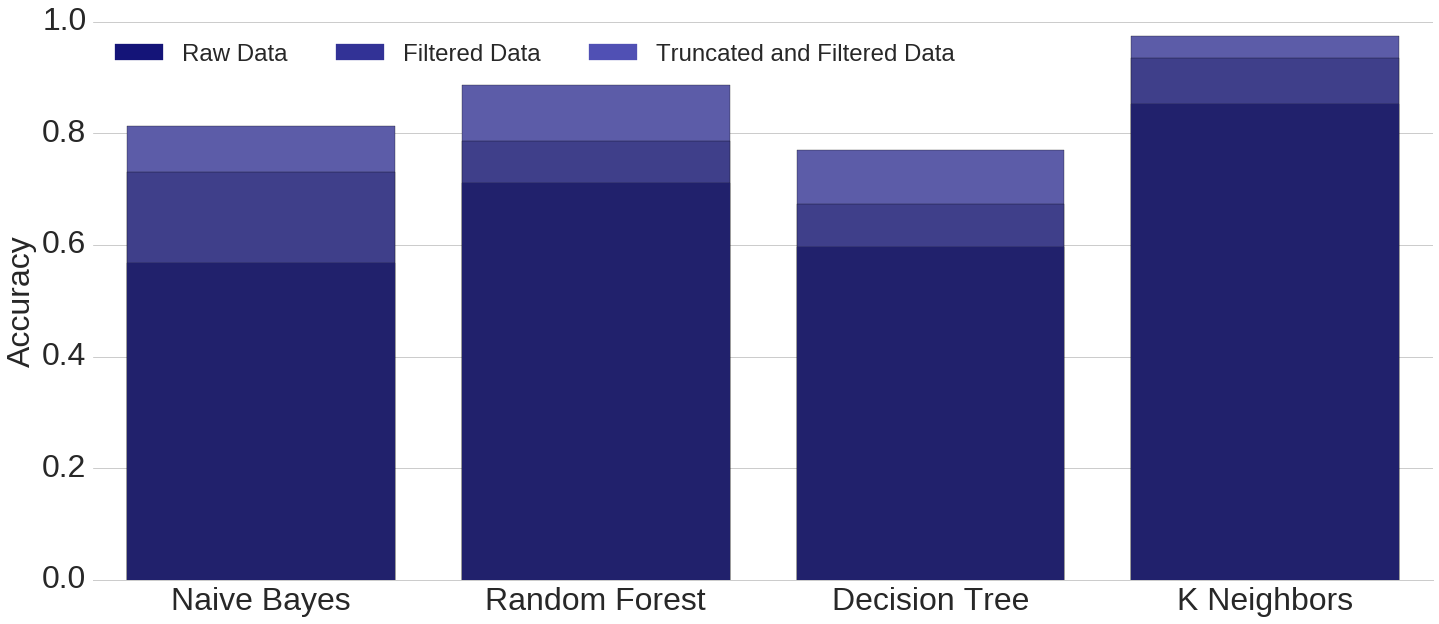

In [76]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
c  = ['Naive Bayes','Random Forest','Decision Tree','K Neighbors']#,'Dynamic Time Warping']
#Read in data & create total column
stacked_bar_data = pd.DataFrame(Accuracies)
stacked_bar_data["total"] = np.sum(Accuracies,axis = 1)

#Set general plot properties
#sns.set_style("white")
sns.set_style('whitegrid')
sns.set_context({"figure.figsize": (24, 10)})

c1 = '#141478'
c2 = '#323296'
c3 = '#5050B4'


#Plot 1 - background - "total" (top) series
sns.barplot(x = c, y = stacked_bar_data[2], color = c3)

#Plot 2 - overlay - "bottom" series
#middle_plot = 
sns.barplot(x = c, y = stacked_bar_data[1], color = c2)

#bottom_plot = 
sns.barplot(x = c, y = stacked_bar_data[0], color = c1)

tick = range(0,101,10)

topbar = plt.Rectangle((0,0),1,1,fc=c3, edgecolor = c3)
middlebar = plt.Rectangle((0,0),1,1,fc=c2,  edgecolor = c2)
bottombar = plt.Rectangle((0,0),1,1,fc=c1,  edgecolor = c1)

bottom_plot = sns.barplot(x = c, y = stacked_bar_data[0], color = c1,linewidth = 0 )

l = plt.legend([bottombar, middlebar,topbar], ['Raw Data','Filtered Data','Truncated and Filtered Data'],
               loc=2, ncol = 3, prop={'size':24})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Accuracy")
#bottom_plot.set_xlabel("Classifier")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(32)

In [36]:
stacked_bar_data.head()

,0,1,2,total
0,0.578980,0.734286,0.804490,2.117755
1,0.713776,0.788367,0.895306,2.397449
2,0.590306,0.683061,0.773673,2.047041
3,0.846020,0.933571,0.973980,2.753571
4,0.950820,0.622951,0.786885,2.360656


In [100]:
c_test = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,
                   2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
                   3,3,3,2,3,2,2,3,3,3,3,3,3,3,3,3,
                   4,4,4,4,4,4,4,4,4,4,4,4,])

test_dict = {'0':'quick_turn','1':'arm_out','2':'O','3':'V','4':'tap'}


actual = np.array(Data[:,-1])

num = 0
den = 0
for row,value in enumerate(c_test):
    if row < 67:
        if actual[row]!='across':
            den += 1
            if test_dict[str(value)]==actual[row]:
                num +=1
print num/float(den)
    

0.946428571429
